# 03 - Regresión lineal para tiempo total de fabricación

Notebook simplificado: predice el **tiempo total estimado** (fabricación + incidencias) para una referencia y cantidad, usando solo `ref_id_str` y `cantidad_lanzada`.

In [15]:
## 1. Importación de librerías y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración general
random_state = 42
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [18]:
## 2. Carga del dataset y exploración básica
data_path = Path('../data/processed/of_vida_model_ready.csv')

df = pd.read_csv(data_path)

# Conversión de columnas temporales (consulta, no usadas en el modelo)
for col in ['primera_fase_ts', 'ultima_fase_ts']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Tiempo total = fabricación + incidencias
df['tiempo_total_min'] = df['y_fabricacion_min'] + df['incidencias_duracion_total']

print('Shape del dataset:', df.shape)
print('Tipos de datos principales:')
print(df[['ref_id_str', 'cantidad_lanzada', 'y_fabricacion_min', 'incidencias_duracion_total', 'tiempo_total_min']].dtypes)

print('Primeras filas:')
display(df.head())

num_cols = ['cantidad_lanzada', 'y_fabricacion_min', 'incidencias_duracion_total', 'tiempo_total_min']
print('Descripción de columnas numéricas relevantes:')
display(df[num_cols].describe())

num_refs = df['ref_id_str'].nunique()
print(f"Número de referencias únicas: {num_refs}")
conteo_refs = df['ref_id_str'].value_counts()
print('Órdenes por referencia (top 10):')
display(conteo_refs.head(10).to_frame('num_ordenes'))

Shape del dataset: (137, 71)
Tipos de datos principales:
ref_id_str                    object
cantidad_lanzada               int64
y_fabricacion_min              int64
incidencias_duracion_total     int64
tiempo_total_min               int64
dtype: object
Primeras filas:


,work_order_id,ref_id_str,cantidad_lanzada,cantidad_final_ok,scrap_total,tiempo_total_min,primera_fase_ts,ultima_fase_ts,y_fabricacion_min,incidencias_duracion_total,...,scrap_normalizado,scrap_rectificado,scrap_sacar_entrad,scrap_soldadura_re,scrap_soldar_rebab,scrap_tallado,scrap_tallar,scrap_templar_por,scrap_temple_reven,scrap_torneado
0,24/0712,031100,9753,9620,133,24532,2025-01-07 02:03:00,2025-01-23 00:26:00,22943,1589,...,0.00,44.00,NaN,16.00,NaN,22.00,NaN,NaN,NaN,NaN
1,24/0722,008091,2596,2525,71,34096,2025-01-16 06:54:00,2025-02-07 15:01:00,32167,1929,...,0.00,13.00,NaN,9.00,NaN,35.00,NaN,NaN,6.00,NaN
2,24/0728,092901,1000,953,47,128455,2025-01-08 16:17:00,2025-04-07 13:54:00,128017,438,...,NaN,NaN,NaN,14.00,NaN,NaN,NaN,NaN,NaN,0.00
3,24/0733,124203,9247,9149,98,47997,2025-01-09 07:35:00,2025-02-07 20:44:00,42549,5448,...,0.00,47.00,NaN,12.00,NaN,20.00,NaN,NaN,NaN,17.00
4,24/0734,124203,2639,2614,25,52857,2025-01-15 12:09:00,2025-02-20 05:58:00,51469,1388,...,0.00,13.00,NaN,5.00,NaN,1.00,NaN,NaN,NaN,0.00


Descripción de columnas numéricas relevantes:


,cantidad_lanzada,y_fabricacion_min,incidencias_duracion_total,tiempo_total_min
count,137.00,137.00,137.00,137.00
mean,"3,767.27","41,350.28","1,983.21","43,333.50"
std,"2,208.10","37,204.36","1,891.57","37,512.51"
min,500.00,"8,795.00",168.00,"9,585.00"
25%,"2,300.00","19,400.00",790.00,"21,017.00"
50%,"3,058.00","30,082.00","1,345.00","31,820.00"
75%,"5,000.00","45,887.00","2,306.00","47,572.00"
max,"14,215.00","284,151.00","10,580.00","285,906.00"


Número de referencias únicas: 31
Órdenes por referencia (top 10):


,num_ordenes
ref_id_str,
124203,19
031100,14
081290,11
081303,10
902081,9
081906,8
081GJ1,7
086503,7
091177,6


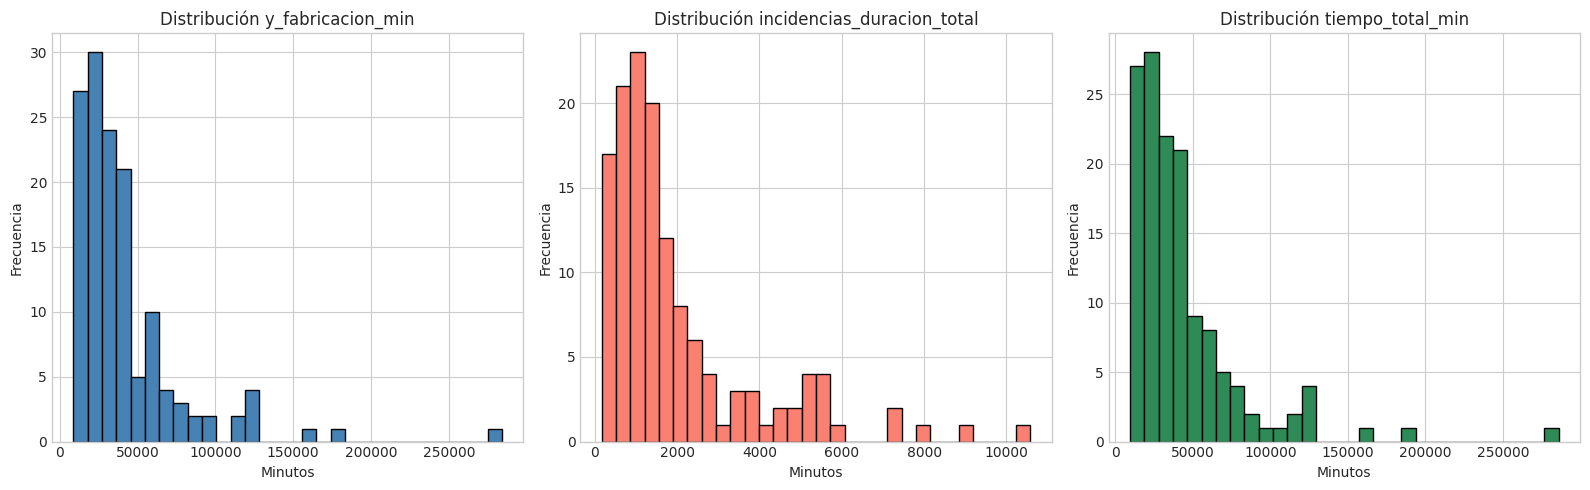

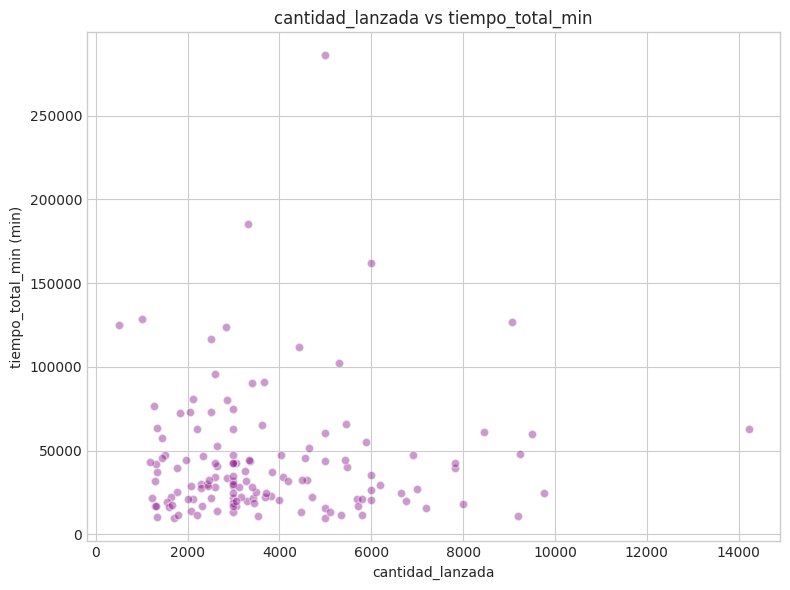

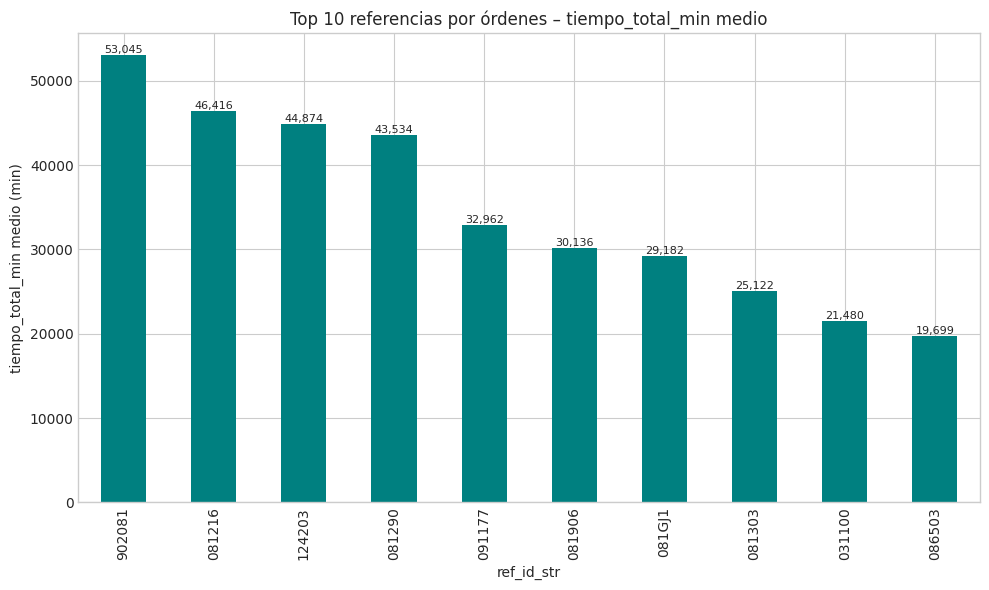

In [19]:
## 3. Gráficos exploratorios
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].hist(df['y_fabricacion_min'].dropna(), bins=30, color='steelblue', edgecolor='black')
axes[0].set_title('Distribución y_fabricacion_min')
axes[0].set_xlabel('Minutos')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(df['incidencias_duracion_total'].dropna(), bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Distribución incidencias_duracion_total')
axes[1].set_xlabel('Minutos')
axes[1].set_ylabel('Frecuencia')

axes[2].hist(df['tiempo_total_min'].dropna(), bins=30, color='seagreen', edgecolor='black')
axes[2].set_title('Distribución tiempo_total_min')
axes[2].set_xlabel('Minutos')
axes[2].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['cantidad_lanzada'], df['tiempo_total_min'], alpha=0.4, color='purple', edgecolor='white')
plt.title('cantidad_lanzada vs tiempo_total_min')
plt.xlabel('cantidad_lanzada')
plt.ylabel('tiempo_total_min (min)')
plt.tight_layout()
plt.show()

top_refs = df['ref_id_str'].value_counts().head(10).index
ref_mean_total = df[df['ref_id_str'].isin(top_refs)].groupby('ref_id_str')['tiempo_total_min'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ref_mean_total.plot(kind='bar', color='teal')
plt.title('Top 10 referencias por órdenes – tiempo_total_min medio')
plt.xlabel('ref_id_str')
plt.ylabel('tiempo_total_min medio (min)')
for idx, val in enumerate(ref_mean_total.values):
    plt.text(idx, val, f"{val:,.0f}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

In [20]:
## 4. Definición de features y target
features_X = ['ref_id_str', 'cantidad_lanzada']
target_total = 'tiempo_total_min'

X = df[features_X].copy()
y_total = df[target_total].copy()

In [21]:
## 5. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_total, test_size=0.2, random_state=random_state, shuffle=True
)

print('Shapes:')
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

Shapes:
X_train: (109, 2)
X_test: (28, 2)
y_train: (109,)
y_test: (28,)


In [22]:
## 6. Preprocesado (OneHotEncoder + columna numérica)
categorical_features = ['ref_id_str']
numeric_features = ['cantidad_lanzada']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)

In [23]:
## 7. Entrenamiento de modelo (Regresión Lineal)
linear_model = LinearRegression()

pipe_total = Pipeline([('preprocess', preprocessor), ('model', linear_model)])
pipe_total.fit(X_train, y_train)

# Predicciones en test
y_pred = pipe_total.predict(X_test)

Métricas para tiempo_total_min:


,MAE_min,MAE_horas,MAE_dias,RMSE_min,R2,MAPE_porcentaje
LinearRegression,"21,740.04",362.33,15.10,"26,655.39",-0.57,92.79


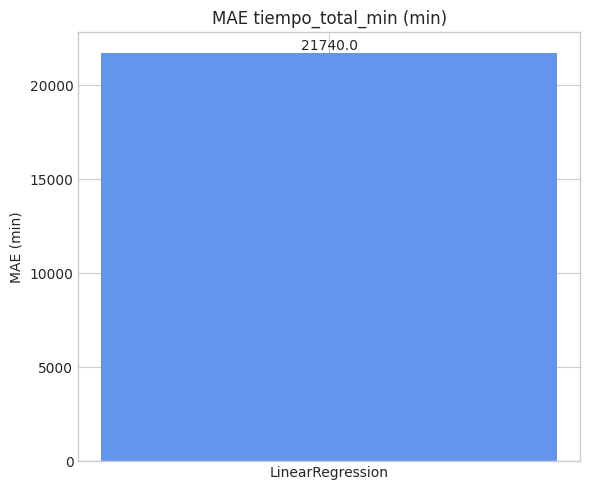

In [24]:
## 8. Evaluación del modelo
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.where(y_true == 0, np.nan, np.abs(y_true))
    return np.nanmean(np.abs(y_true - y_pred) / denom) * 100


def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    # En tu versión de sklearn no existe squared=False → sacamos la raíz a mano
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'MAE_min': mae,
        'MAE_horas': mae / 60,
        'MAE_dias': mae / (60 * 24),
        'RMSE_min': rmse,
        'R2': r2,
        'MAPE_porcentaje': mape,
    }

metrics_total = compute_metrics(y_test, y_pred)
metrics_total_df = pd.DataFrame([metrics_total], index=['LinearRegression'])

print('Métricas para tiempo_total_min:')
display(metrics_total_df)

# Gráfico simple
plt.figure(figsize=(6, 5))
plt.bar(['LinearRegression'], metrics_total_df['MAE_min'], color='cornflowerblue')
plt.title('MAE tiempo_total_min (min)')
plt.ylabel('MAE (min)')
plt.bar_label(plt.gca().containers[0], fmt='%.1f')
plt.tight_layout()
plt.show()

In [25]:
## 9. Ejemplos reales del test: tabla comparativa
n_samples = min(5, len(X_test))
sample_indices = X_test.sample(n=n_samples, random_state=random_state).index

comparativa_df = X_test.loc[sample_indices].copy()
comparativa_df['tiempo_total_real'] = y_test.loc[sample_indices]
comparativa_df['pred_tiempo_total'] = pipe_total.predict(X_test.loc[sample_indices])

# Formateo más legible
comparativa_df = comparativa_df[['ref_id_str', 'cantidad_lanzada', 'tiempo_total_real', 'pred_tiempo_total']]

print('Comparativa de valores reales vs predicciones (muestra del test):')
display(comparativa_df)

Comparativa de valores reales vs predicciones (muestra del test):


,ref_id_str,cantidad_lanzada,tiempo_total_real,pred_tiempo_total
85,081901,1191,43379,"20,847.66"
100,081216,5713,16714,"65,172.26"
133,086503,7190,15489,"33,995.81"
4,124203,2639,52857,"36,143.44"
105,081906,3329,44169,"32,800.56"


In [27]:
## 10. Función para probar escenarios manuales
def predecir_escenario(ref_id, cantidad, model, known_refs):
    if ref_id not in known_refs:
        raise ValueError(f"La referencia {ref_id} no está en el histórico de entrenamiento. No se generan predicciones.")

    input_df = pd.DataFrame({'ref_id_str': [ref_id], 'cantidad_lanzada': [cantidad]})
    pred_total = model.predict(input_df)[0]

    return pd.DataFrame([
        {
            'modelo': 'LinearRegression',
            'ref_id_str': ref_id,
            'cantidad_lanzada': cantidad,
            'pred_tiempo_total_min': pred_total,
            'pred_tiempo_total_horas': pred_total / 60,
            'pred_tiempo_total_dias': pred_total / (60 * 24),
        }
    ])

known_refs = set(X_train['ref_id_str'].unique())
print(f"Número de referencias conocidas (entrenamiento): {len(known_refs)}")

if known_refs:
    ref_ejemplo = list(known_refs)[0]
    ejemplo_df = predecir_escenario(ref_ejemplo, 5000, pipe_total, known_refs)
    print(f"Predicciones para ref_id_str={ref_ejemplo}, cantidad_lanzada=5000:")
    display(ejemplo_df)
else:
    print('No hay referencias en el entrenamiento para el ejemplo.')

Número de referencias conocidas (entrenamiento): 28
Predicciones para ref_id_str=081901, cantidad_lanzada=5000:


,modelo,ref_id_str,cantidad_lanzada,pred_tiempo_total_min,pred_tiempo_total_horas,pred_tiempo_total_dias
0,LinearRegression,081901,5000,"37,302.55",621.71,25.90


In [28]:
## 11. Comprobación final: referencia desconocida
try:
    _ = predecir_escenario('999999', 5000, pipe_total, known_refs)
except ValueError as e:
    print('Comportamiento con referencia desconocida:')
    print(e)

Comportamiento con referencia desconocida:
La referencia 999999 no está en el histórico de entrenamiento. No se generan predicciones.
